In [128]:
import os
import sys

sys.path.append('../../txf_design-space/')
sys.path.append('../../txf_design-space/flexibert')
sys.path.append('../../boshnas/boshnas/')
sys.path.append('../utils')
sys.path.append('../')

import yaml
import json
import time
import torch
import shlex
import shutil
import argparse
import subprocess
import collections
import numpy as np
from tqdm import tqdm, tqdm_notebook

from embeddings.utils import graph_util, print_util as pu

sys.path.append('../../txf_design-space/transformers/src/transformers')
import embedding_util, energy_util

from boshnas import BOSHNAS
from acq import gosh_acq as acq

from transformers import BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers.models.bert.configuration_bert import BertConfig
from transformers.models.bert.modeling_modular_bert import BertModelModular, BertForMaskedLMModular, BertForSequenceClassificationModular

import warnings
warnings.filterwarnings("ignore")

from run_energy_profiler import *

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

from six.moves import cPickle as pickle
from scipy.interpolate import griddata
from sklearn.tree import plot_tree
from scipy.optimize import minimize, differential_evolution

In [35]:
# Load design space
design_space = yaml.safe_load(open('../design_space/design_space.yaml'))

# Load dataset
dataset = json.load(open('../dataset/dataset_test.json'))
for key in dataset.keys():
    dataset[key]['embedding'] = eval(dataset[key]['embedding'])
    
X, latency, energy, peak_power = convert_to_tabular(dataset)
max_latency, max_energy, max_peak_power = np.amax(latency), np.amax(energy), np.amax(peak_power)

mean_X = np.mean(X, axis=0)

# Increase maximum values
max_latency, max_energy, max_peak_power = 1.2 * max_latency, 1.2 * max_energy, 1.2 * max_peak_power
print(f'Max latency: {max_latency : 0.3f}s/seq. Max energy: {max_energy : 0.3f}J/seq. Max peak power: {max_peak_power : 0.3f}W')
    
latency, energy, peak_power = latency/max_latency, energy/max_energy, peak_power/max_peak_power
    
# Get the embedding for model with hash in the first entry
model_hash = list(dataset.keys())[0]
print(np.array(dataset[model_hash]['embedding'])) 

surrogate_models = \
    init_surrogate_models('boshnas', dataset, design_space, '../dataset/surrogate_models/', True)

X_ds = convert_to_tabular({model_hash: dataset[model_hash]}, only_embeddings=True)

# We see a non-zero epistemic uncertainty
get_predictions(surrogate_models, X_ds-mean_X)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/dataset_test.json'

In [ ]:
get_predictions(surrogate_models, (X-mean_X)/max_X)

In [ ]:
# Train surrogate models on the normalized dataset
train_surrogate_models(surrogate_models, (X-mean_X)/max_X, latency, energy, peak_power)

# We see a non-zero epistemic uncertainty
get_predictions(surrogate_models, (X-mean_X)/max_X)

In [ ]:
latency, energy, peak_power

In [ ]:
# Get random samples of the entire dataset to obtain maximum uncertainty
random_samples = embedding_util.get_samples(design_space, num_samples=128, sampling_method='Random', debug=True)
X_ds = convert_to_tabular(random_samples, only_embeddings=True)

# get_predictions(surrogate_models, (X_ds-mean_X)/max_X)

In [ ]:
len(set(random_samples.keys()).difference(set(dataset.keys())))

In [ ]:
# Test GP
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(random_state=0)
gpr.fit(X, latency)

print(gpr.predict(X, return_std=True))
gpr.predict(X_ds, return_std=True)

In [15]:
# Test different regressors on the dataset
regressors = ['GP', 'DT', 'BDT', 'BOSHNAS']

X, latency, energy, peak_power = X[:2048, :], latency[:2048], energy[:2048], peak_power[:2048]
X_train, latency_train = X[:16, :], latency[:16]
X_test, latency_test = X[16:20, :], latency[16:20]

for regressor in regressors:
    if regressor == 'BOSHNAS':
        embedding_dim = len(dataset[list(dataset.keys())[0]]['embedding'])
        embedding_bounds = embedding_util.get_embedding_bounds(design_space, 'all')
        embedding_bounds = (np.array([bound[0] for bound in embedding_bounds]), np.array([bound[1] for bound in embedding_bounds]))

        latency_model = BOSHNAS(input_dim=embedding_dim,
            bounds=embedding_bounds,
            trust_region=False,
            second_order=True,
            parallel=True,
            model_aleatoric=False,
            save_path='./surrogate_models_test',
            pretrained=False)
        
        latency_model.train(X_train, latency_train)
        latency_predictions = latency_model.predict(X_test)
        latency_predictions = np.array([pred[0].item() for pred in latency_predictions])
    elif regressor == 'GP':
        gpr = GaussianProcessRegressor(random_state=0)
        gpr.fit(X_train, latency_train)
        latency_predictions = gpr.predict(X_test)
    elif regressor == 'DT':
        dtr = DecisionTreeRegressor(random_state=0)
        dtr.fit(X_train, latency_train)
        latency_predictions = dtr.predict(X_test)
    elif regressor == 'BDT':
        bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=500)
        bdtr.fit(X_train, latency_train)
        latency_predictions = bdtr.predict(X_test)
    print(f'MSE for {regressor}:\t{mean_squared_error(latency_test, latency_predictions): 0.5f}')

MSE for GP:	 0.19556
MSE for DT:	 0.00666
MSE for BDT:	 0.00099
MSE for BOSHNAS:	 0.19556


In [16]:
# Grid search validation of n_estimators for BDT
n_estimators_list = [5, 10, 50, 100, 200, 300, 500, 1000]

for n_estimators in n_estimators_list:
    bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=n_estimators)
    bdtr.fit(X_train, latency_train)
    latency_predictions = bdtr.predict(X_test)
    print(f'MSE for BDT with {n_estimators} trees:\t{mean_squared_error(latency_test, latency_predictions): 0.5f}')

MSE for BDT with 5 trees:	 0.00378
MSE for BDT with 10 trees:	 0.00202
MSE for BDT with 50 trees:	 0.00264
MSE for BDT with 100 trees:	 0.00249
MSE for BDT with 200 trees:	 0.00085
MSE for BDT with 300 trees:	 0.00099
MSE for BDT with 500 trees:	 0.00070
MSE for BDT with 1000 trees:	 0.00099


In [4]:
sample_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048]
regressors = ['GP', 'DT', 'BDT', 'BOSHNAS']
max_uncertainties = {'GP': [], 'DT': [], 'BDT': [], 'BOSHNAS': []}
min_uncertainties = {'GP': [], 'DT': [], 'BDT': [], 'BOSHNAS': []}
mse = {'GP': [], 'DT': [], 'BDT': [], 'BOSHNAS': []}

for sample_size in sample_sizes:
    X_train_small, latency_train_small = X[:sample_size, :], latency[:sample_size]
    X_test_small, latency_test_small = X[sample_size:int(sample_size+128), :], latency[sample_size:int(sample_size+128)]

    for regressor in regressors:
        if regressor == 'GP':
            gpr = GaussianProcessRegressor(random_state=0)
            gpr.fit(X_train_small, latency_train_small)
            latency_predictions, uncertainty = gpr.predict(X_test_small, return_std=True)
        elif regressor == 'BOSHNAS':
            embedding_dim = len(dataset[list(dataset.keys())[0]]['embedding'])
            embedding_bounds = embedding_util.get_embedding_bounds(design_space, 'all')
            embedding_bounds = (np.array([bound[0] for bound in embedding_bounds]), np.array([bound[1] for bound in embedding_bounds]))

            latency_model = BOSHNAS(input_dim=embedding_dim,
                bounds=embedding_bounds,
                trust_region=False,
                second_order=True,
                parallel=True,
                model_aleatoric=False,
                save_path='./surrogate_models_test',
                pretrained=False)

            latency_model.train(X_train_small, latency_train_small)
            latency_predictions_all = latency_model.predict(X_test_small)
            latency_predictions = np.array([pred[0].item() for pred in latency_predictions_all])
            uncertainty = np.array([pred[1][0].item() for pred in latency_predictions_all])
        elif regressor == 'BDT':
            bdtr = AdaBoostRegressor(DecisionTreeRegressor(random_state=0), n_estimators=500)
            bdtr.fit(X_train_small, latency_train_small)

            dt_predictions = []
            for estimator in bdtr.estimators_:
                pred = estimator.predict(X_test_small)
                dt_predictions.append(pred)
            latency_predictions, uncertainty = bdtr.predict(X_test_small), np.std(np.array(dt_predictions), axis=0)
            
        elif regressor == 'DT':
            dtr = DecisionTreeRegressor(random_state=0)
            dtr.fit(X_train_small, latency_train_small)
            latency_predictions, uncertainty = dtr.predict(X_test_small), 0
        
        max_uncertainties[regressor].append(np.amax(uncertainty))
        min_uncertainties[regressor].append(np.amin(uncertainty))
        mse[regressor].append(mean_squared_error(latency_test_small, latency_predictions))

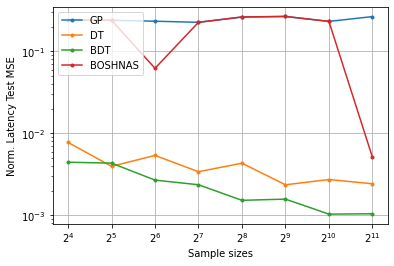

In [17]:
for regressor in regressors:
    plt.plot(sample_sizes, min_uncertainties[regressor], label=regressor)
plt.legend()
plt.xlabel('Sample sizes')
plt.xscale('log', basex=2)
plt.xticks(sample_sizes)
plt.ylabel('Min. Uncertainty')
plt.show()

for regressor in regressors:
    plt.plot(sample_sizes, max_uncertainties[regressor], label=regressor)
plt.legend()
plt.xlabel('Sample sizes')
plt.xscale('log', basex=2)
plt.xticks(sample_sizes)
plt.ylabel('Max. Uncertainty')
plt.show()

for regressor in regressors:
    plt.plot(sample_sizes, mse[regressor], '.-', label=regressor)
plt.legend(loc='upper left')
plt.xlabel('Sample sizes')
plt.xscale('log', basex=2)
plt.yscale('log')
plt.xticks(sample_sizes)
plt.ylabel('Norm. Latency Test MSE')
plt.grid()
plt.savefig('./latency_test_mse.pdf', bbox_inches='tight')
plt.show()

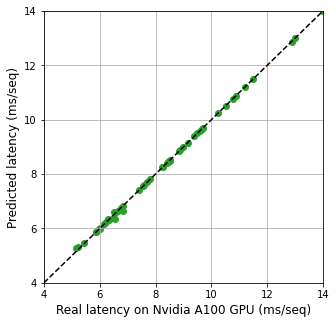

In [77]:
from matplotlib.pyplot import figure

figure(figsize=(5, 5))

sample_size = 256
X_train_small, latency_train_small = X[:int(0.8*sample_size), :], latency[:int(0.8*sample_size)]
X_test_small, latency_test_small = X[int(0.8*sample_size):sample_size, :], latency[int(0.8*sample_size):sample_size]

plt.scatter(latency_test_small*max_latency, bdtr.predict(X_test_small)*max_latency, color='tab:green')
plt.plot(np.arange(0.004, 0.015, 0.001), np.arange(0.004, 0.015, 0.001), '--', color='black')
plt.xlim([0.004, 0.014])
plt.ylim([0.004, 0.014])
plt.xticks(np.arange(0.004, 0.015, 0.002), [4, 6, 8, 10, 12, 14])
plt.yticks(np.arange(0.004, 0.015, 0.002), [4, 6, 8, 10, 12, 14])
plt.grid()
plt.xlabel('Real latency on Nvidia A100 GPU (ms/seq)', fontsize=12)
plt.ylabel('Predicted latency (ms/seq)', fontsize=12)
plt.savefig('./pred_vs_real_latency_bdt.pdf', bbox_inches='tight')

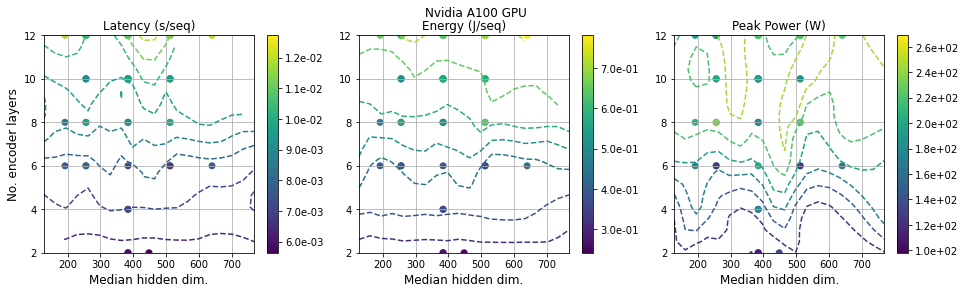

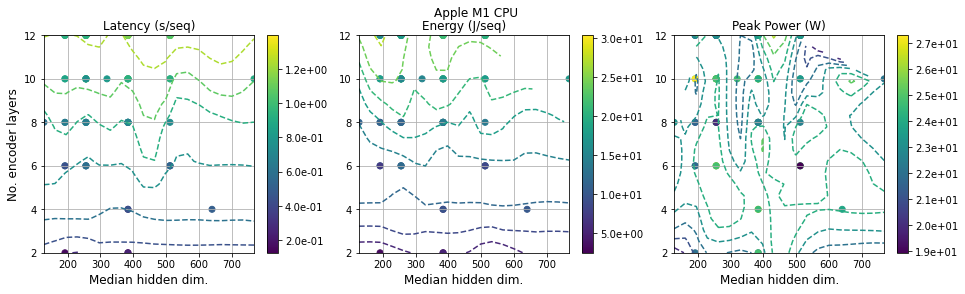

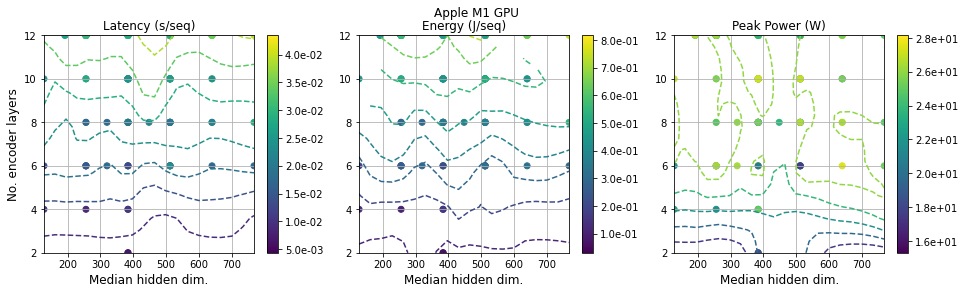

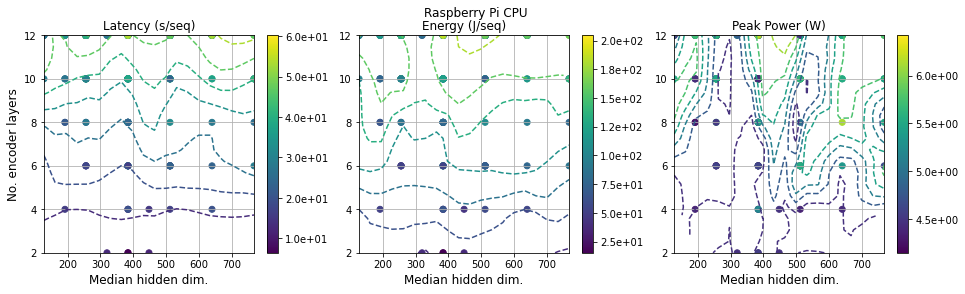

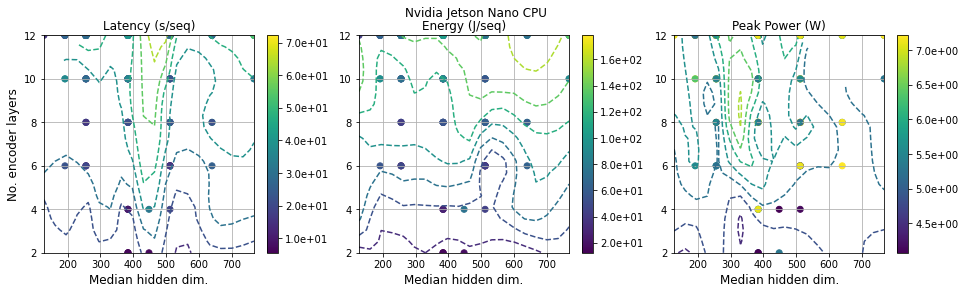

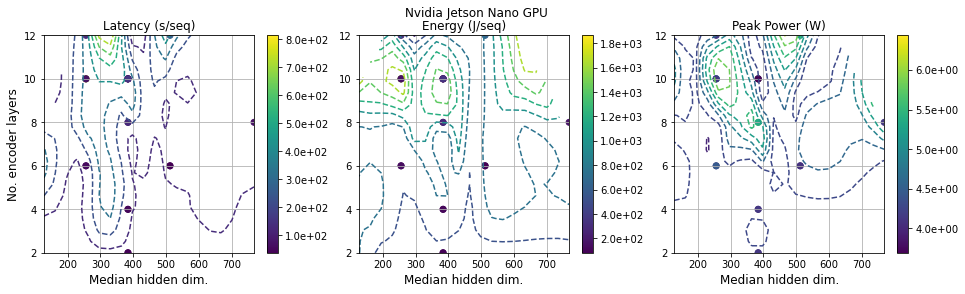

In [137]:
# Make contour plots for latency, energy, peak power
devices = {'gpu_a100_b128_r3': 'Nvidia A100 GPU', 
           'cpu_m1-pro_b32_r1': 'Apple M1 CPU', 
           'gpu_m1-pro_b32_r3': 'Apple M1 GPU',
           'cpu_rpi_b1_r1': 'Raspberry Pi CPU', 
#            'npu_ncs_b1_r1': 'Intel NCS NPU', 
           'cpu_jetson-nano_b1_r1': 'Nvidia Jetson Nano CPU', 
           'gpu_jetson-nano_b1_r1': 'Nvidia Jetson Nano GPU'}

measures = {'latency': 'Latency (s/seq)', 'energy': 'Energy (J/seq)', 'peak_power': 'Peak Power (W)'}

def get_plotting_data(dataset: dict, measure: str, model = None, max_values = None):
    model_depths, median_widths, measure_values = [], [], []
    
    for model_hash in dataset.keys():
        model_dict = dataset[model_hash]['model_dict']

        model_depths.append(model_dict['l'])
        # median_widths.append(np.median([len(attn_ops) for attn_ops in model_dict['o']]))
        median_widths.append(np.median(model_dict['h']))
        if 'performance' in dataset[model_hash].keys():
            measure_values.append(dataset[model_hash]['performance'][measure])
        else:
            measure_values.append(float(model.predict(
                np.array(dataset[model_hash]['embedding']).reshape(1, -1))*max_values['max_' + measure]))
        
    return model_depths, median_widths, measure_values

for device in devices.keys():
    results_dir = f'../results/results_{device}/dataset'
    dataset = json.load(open(os.path.join(results_dir, 'dataset.json')))
    max_values = json.load(open(os.path.join(results_dir, 'surrogate_models', 'max_values.json')))
    
    fig, axs = plt.subplots(1, len(measures), figsize=(16, 4))
    count = 0
    for measure in measures.keys():
        model = pickle.load(open(os.path.join(results_dir, 'surrogate_models', f'{measure}.pkl'), 'rb'))
        
        model_depths, median_widths, measure_values = get_plotting_data(dataset, measure)
            
        sampled_dataset = embedding_util.get_samples(design_space, 256, 'Random')
        pred_depths, pred_widths, pred_values = get_plotting_data(sampled_dataset, measure, model, max_values)
            
        sc = axs[count].scatter(median_widths, model_depths, c=measure_values)
        
        xi = np.linspace(design_space['hidden_size'][0], design_space['hidden_size'][-1], 20)
        yi = np.linspace(design_space['encoder_layers'][0], design_space['encoder_layers'][-1], 20)
        zi = griddata((pred_widths, pred_depths), pred_values, (xi[None,:], yi[:,None]), method='cubic')
        axs[count].contour(xi, yi, zi, linestyles='--')
        
        axs[count].set_xlabel('Median hidden dim.', fontsize=12)
        if count == 0: axs[count].set_ylabel('No. encoder layers', fontsize=12)
        axs[count].set_title(measures[measure])
        fig.colorbar(sc, ax=axs[count], format='%.1e')
        axs[count].grid()
        count += 1
        
    plt.savefig(f'./figures/contour_plots/cp_{device}.pdf', bbxos_inches='tight')
    fig.suptitle(devices[device])
    plt.show()

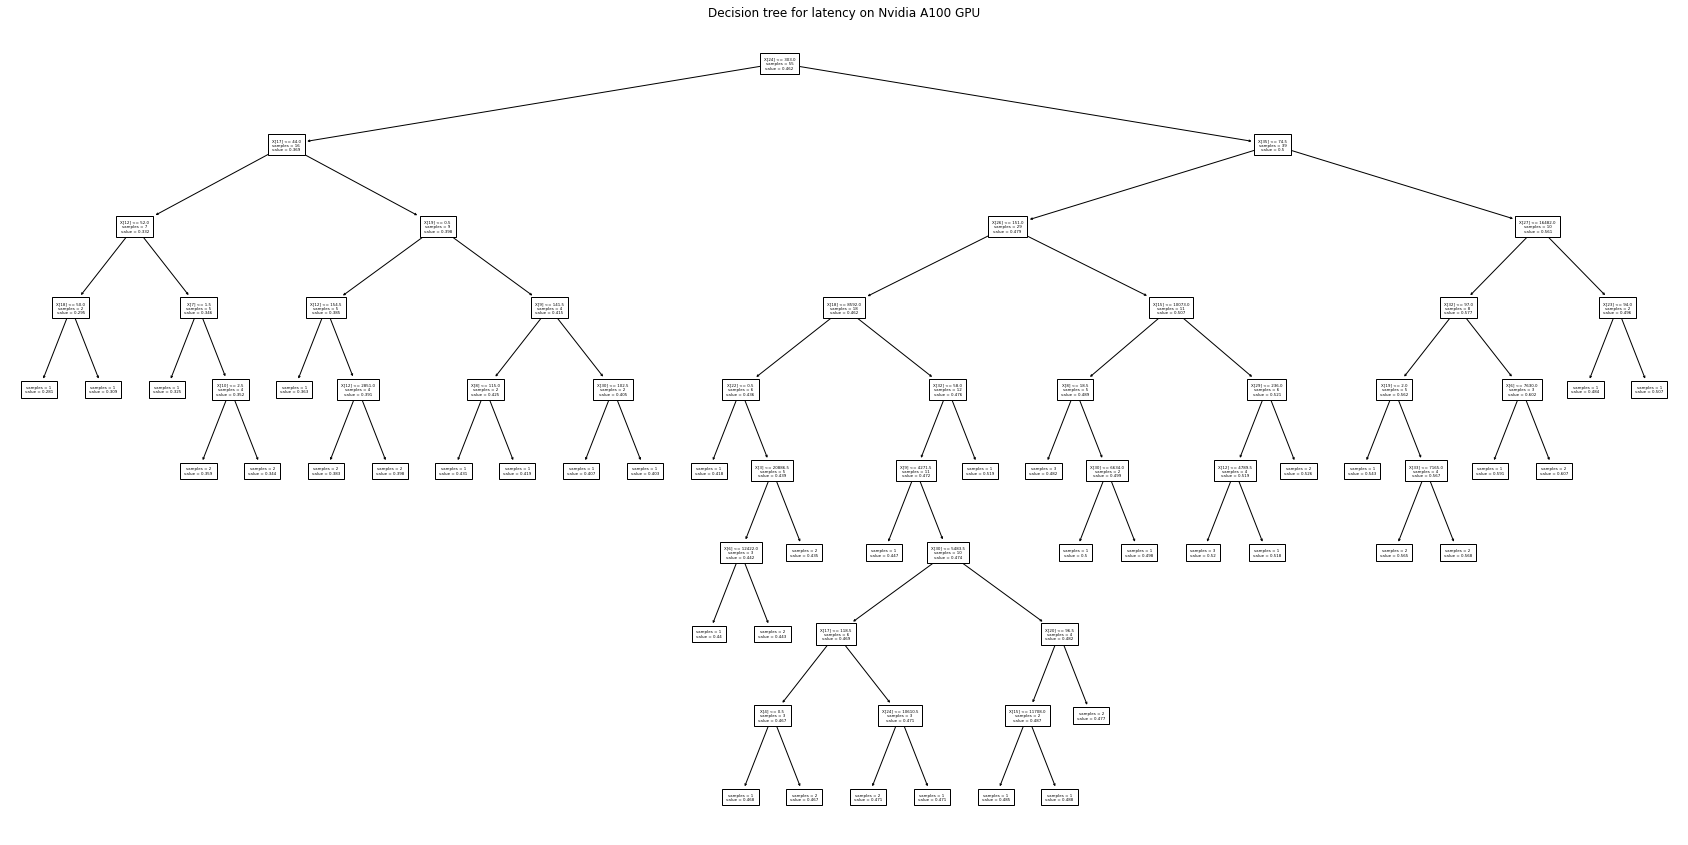

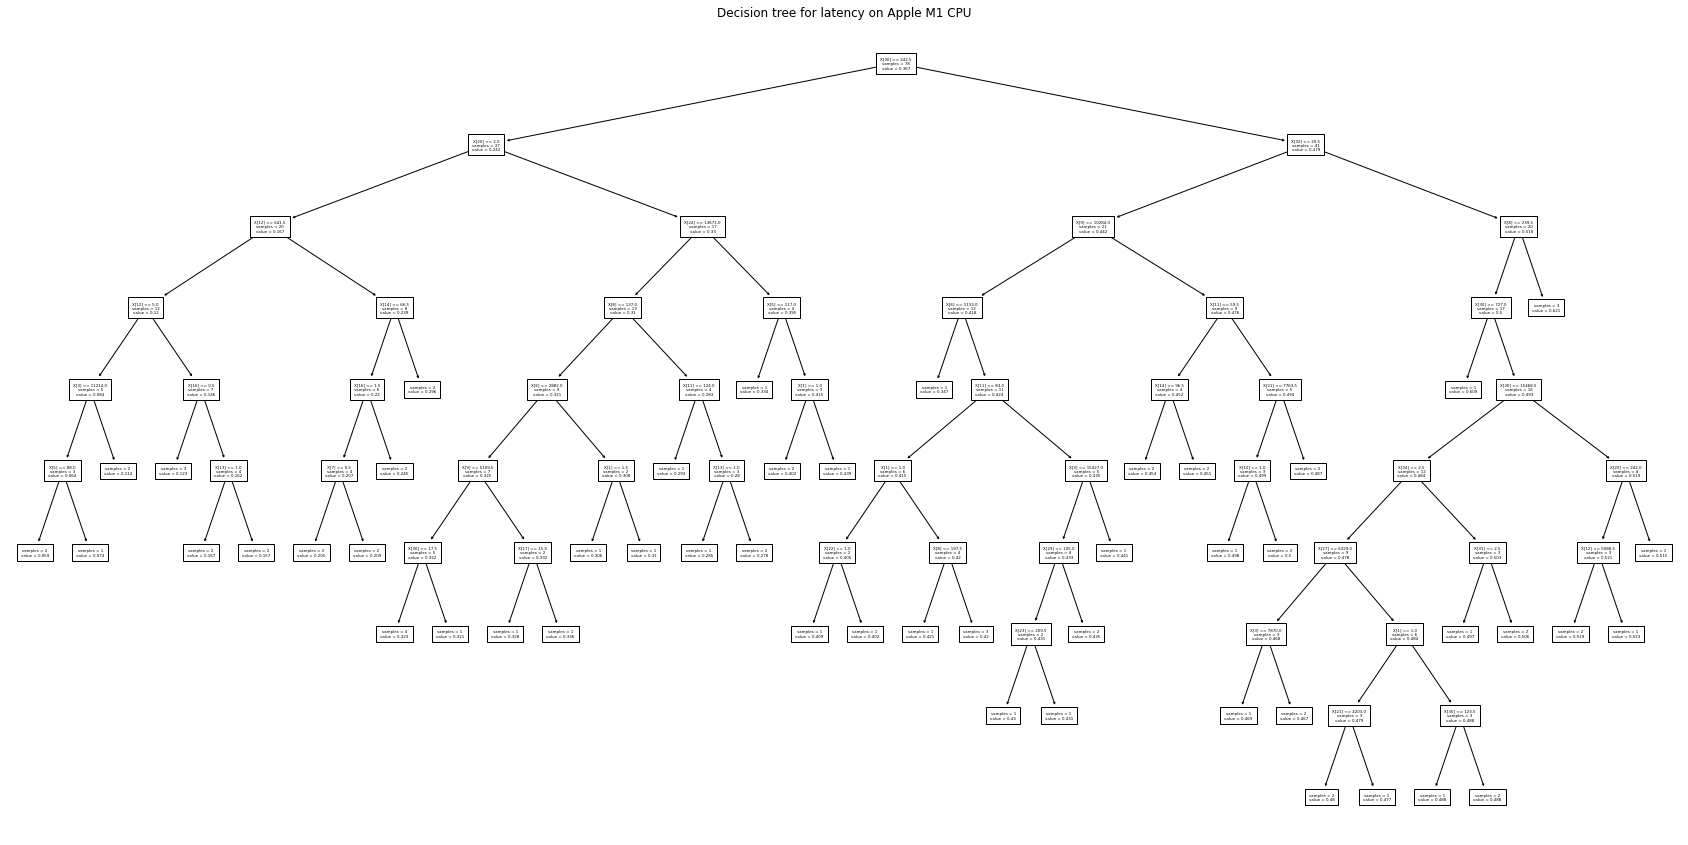

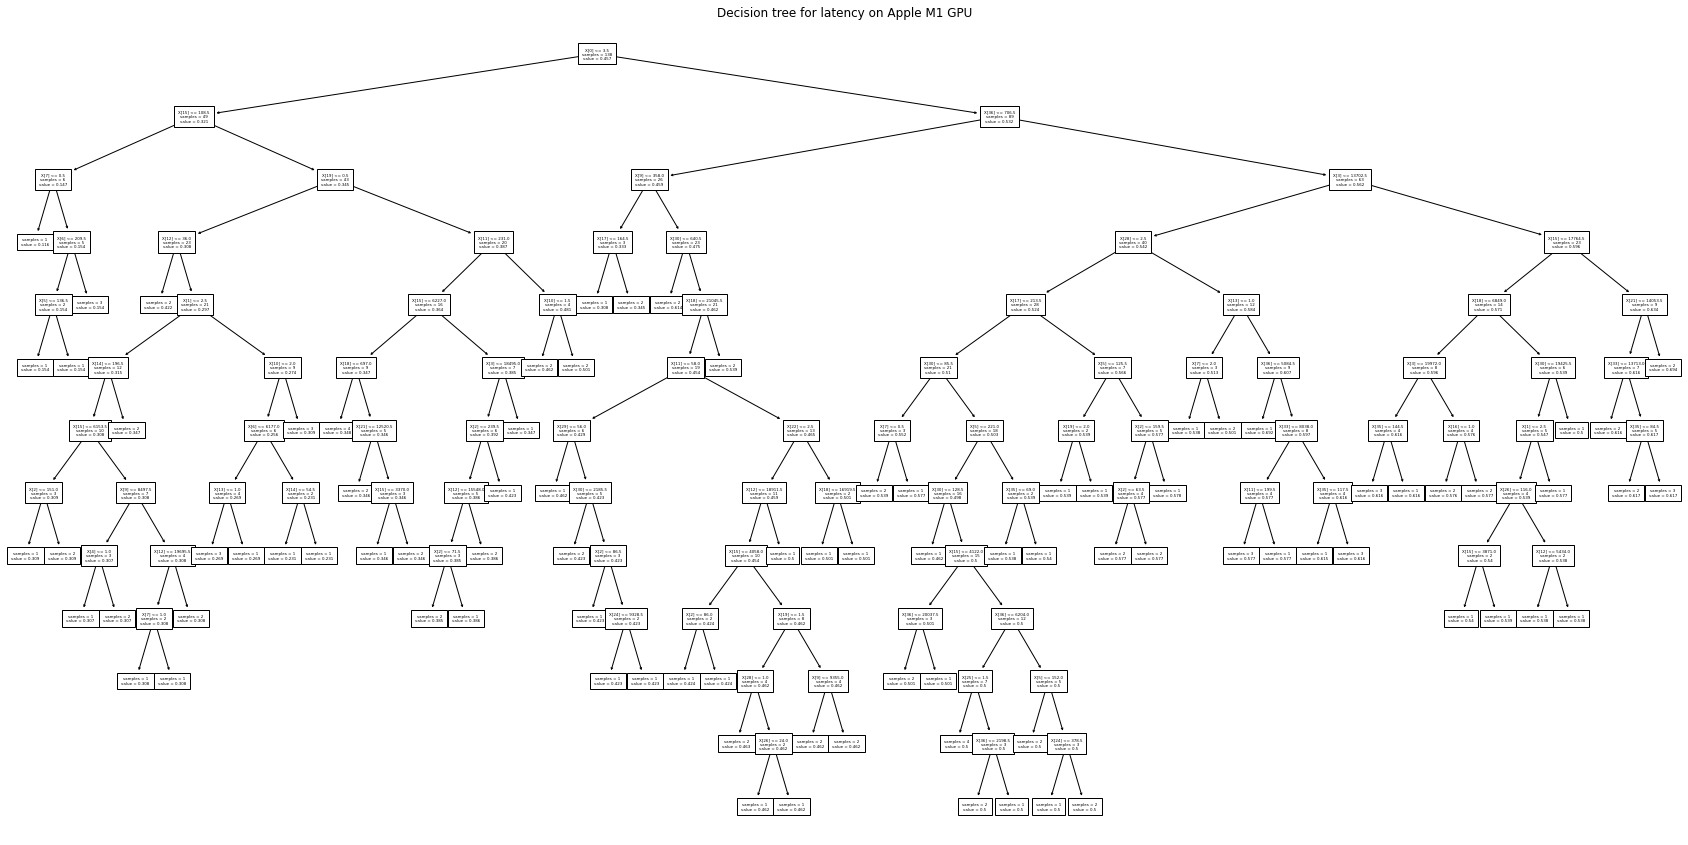

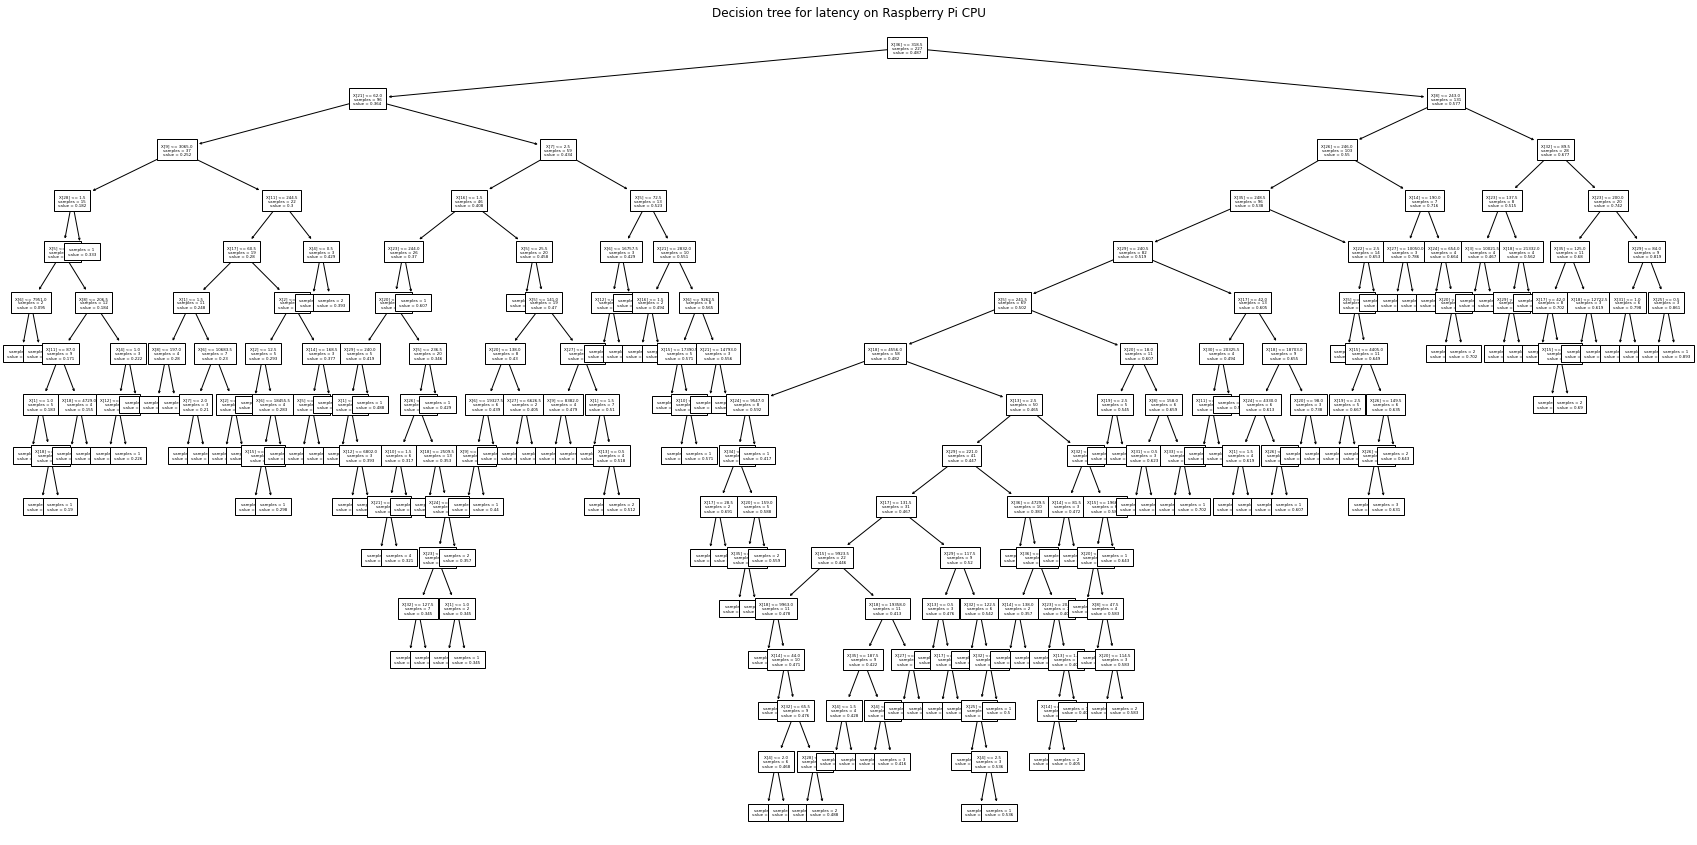

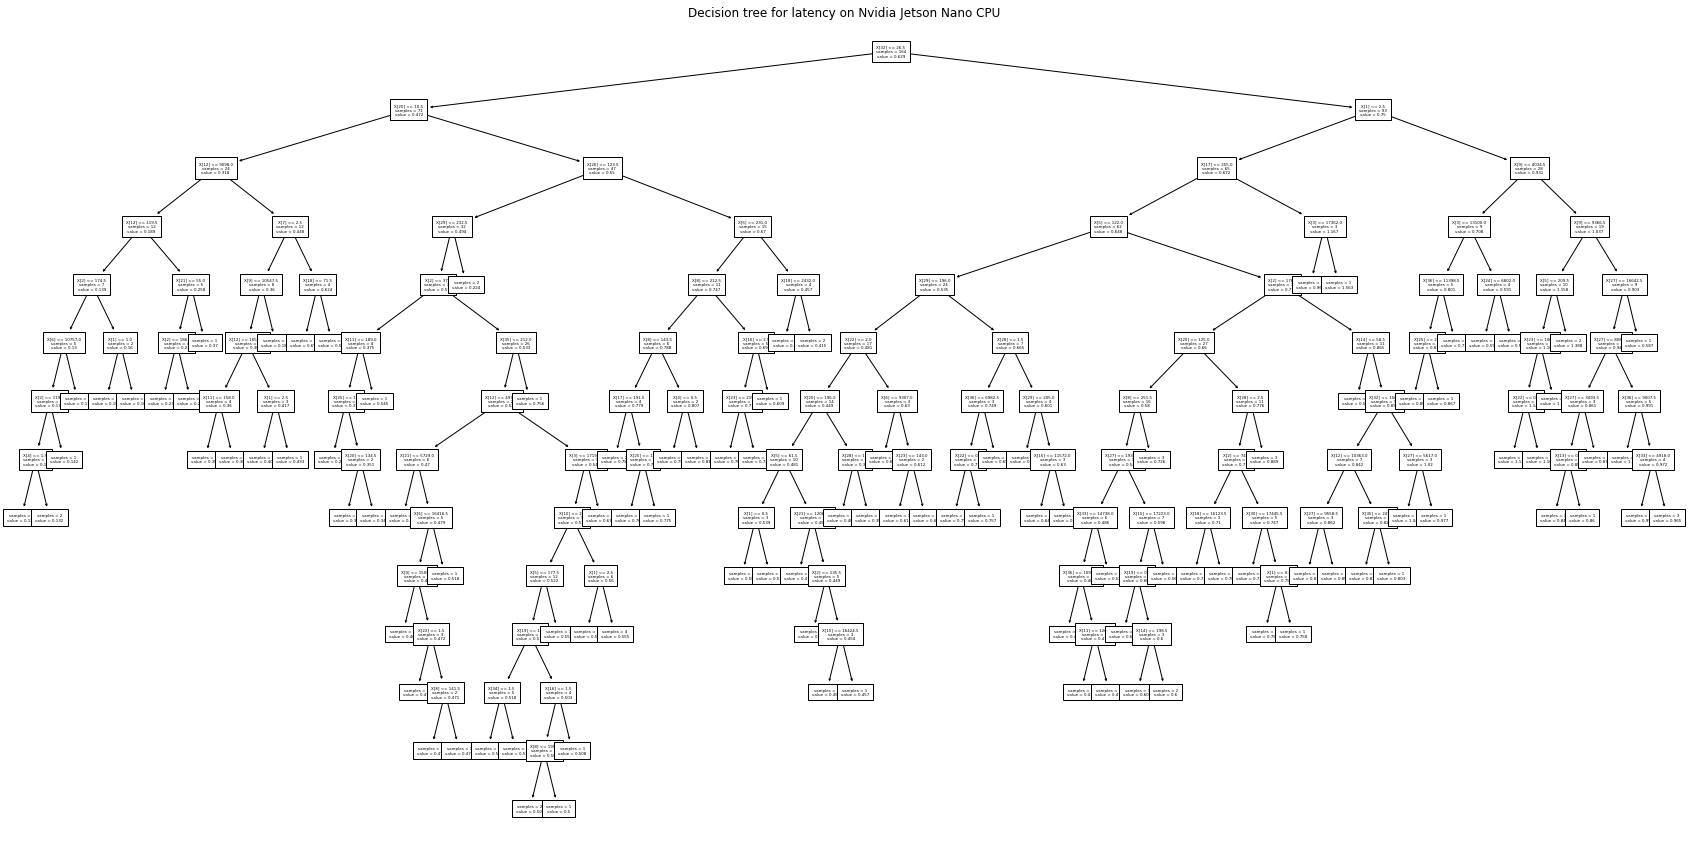

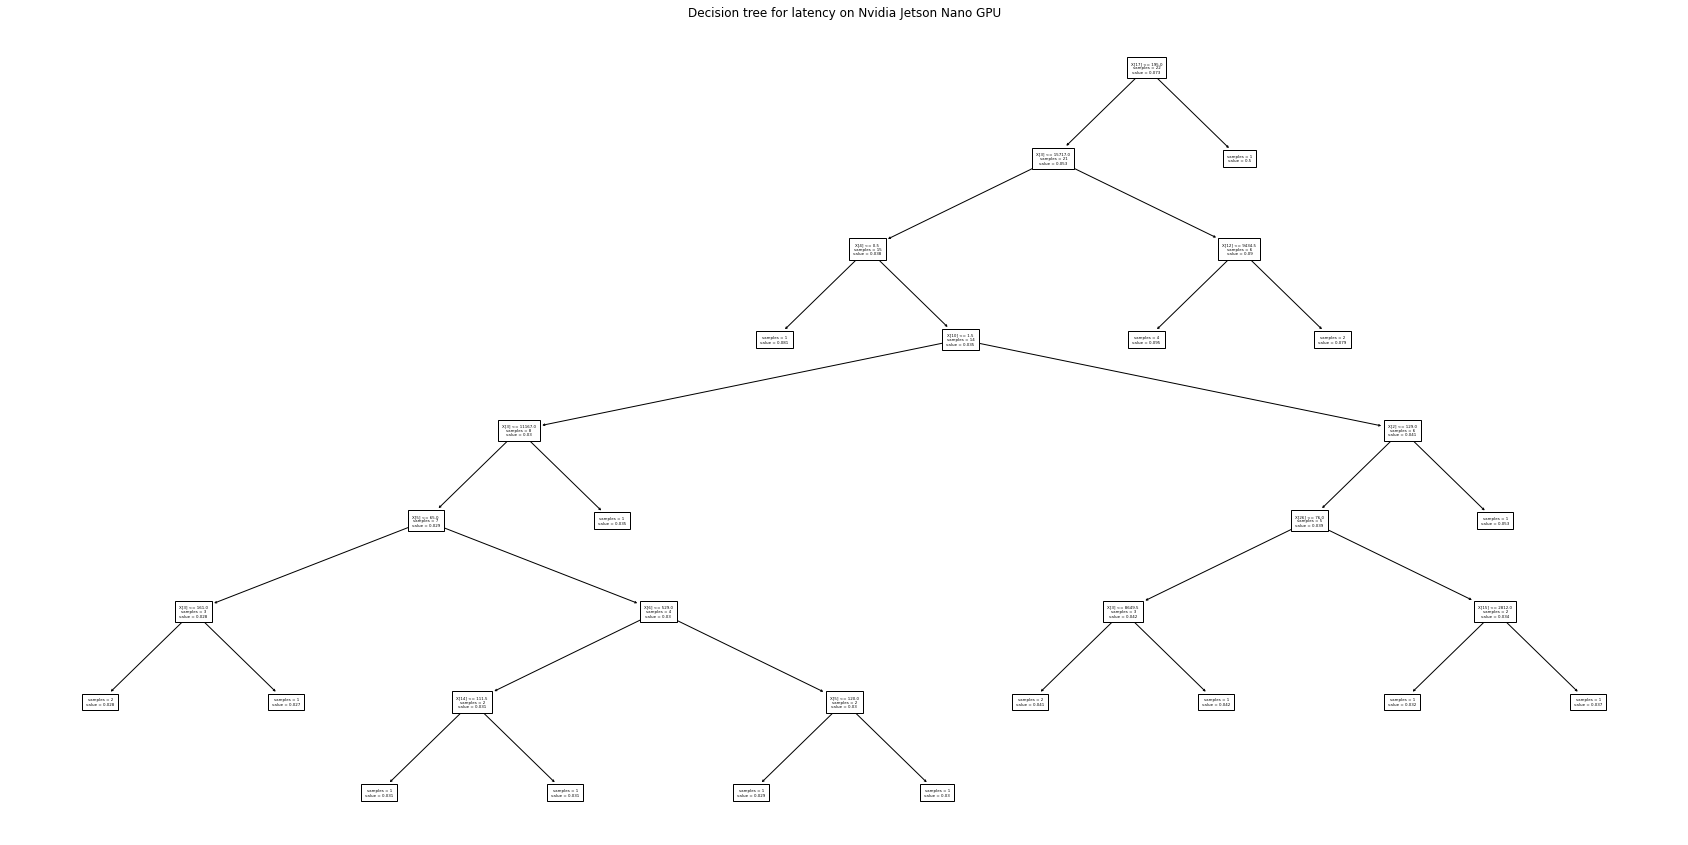

In [84]:
# Plot decison trees
for device in devices.keys():
    results_dir = f'../results/results_{device}/dataset'
    
    # We plot one decion tree for the latency model
    model = pickle.load(open(os.path.join(results_dir, 'surrogate_models', f'latency.pkl'), 'rb'))

    fig, ax = plt.subplots(figsize=(30, 15))
    plot_tree(model.estimators_[0], label='all', impurity=False, fontsize=4)
    plt.savefig(f'./figures/decision_trees/dt_{device}.pdf', bbox_inches='tight')
    plt.title(f'Decision tree for latency on {devices[device]}')
    plt.show()

In [135]:
# Get individually optimal models

def partial_func(i, model):
    return model.predict(i.reshape(1, -1))

# Start with BERT-Tiny's embedding
bert_tiny_model_dict = {"l": 2, "o": 
                        [["sa_sdp_64", "sa_sdp_64"], 
                         ["sa_sdp_64", "sa_sdp_64"]],  
                        "h": [128, 128], "f": [[512], [512]]}
bert_tiny_embedding = embedding_util.model_dict_to_embedding(bert_tiny_model_dict, design_space)

for device in devices.keys():
    print(f'Testing device: {devices[device]}...')
    results_dir = f'../results/results_{device}/dataset'
    
    latency_model = pickle.load(open(os.path.join(results_dir, 'surrogate_models', 'latency.pkl'), 'rb'))
    energy_model = pickle.load(open(os.path.join(results_dir, 'surrogate_models', 'energy.pkl'), 'rb'))
    peak_power_model = pickle.load(open(os.path.join(results_dir, 'surrogate_models', 'peak_power.pkl'), 'rb'))
    
    max_values = json.load(open(os.path.join(results_dir, 'surrogate_models', 'max_values.json')))
    
    for measure in measures.keys():
        model = pickle.load(open(os.path.join(results_dir, 'surrogate_models', f'{measure}.pkl'), 'rb'))
        
        # res = differential_evolution(partial_func, bounds=embedding_util.get_embedding_bounds(design_space),
        #     args=(model,), x0=np.array(bert_tiny_embedding).reshape(1, -1),disp=True, workers=8)
        # embedding = [int(x) for x in res.x.tolist()]
        
        # Apply random search to get a minimum measure model
        min_measure = 1
        pbar = tqdm_notebook(range(10), ncols='100%')
        for i in pbar:
            pbar.set_description(f'Current minimum {measure} - {min_measure: 0.05f}')
            random_samples = embedding_util.get_samples(design_space, num_samples=128, sampling_method='Random')
            X_ds = convert_to_tabular(random_samples, only_embeddings=True)

            predictions = model.predict(X_ds)
            if min(predictions) < min_measure:
                min_embedding = random_samples[list(random_samples.keys())[np.argmin(predictions)]]['embedding']
                min_measure = min(predictions)
        embedding = min_embedding
        
        print(f'Embedding of minimum {measure} model:\n{embedding}')
        print(f'Model dict. of minimum {measure} model:\n{embedding_util.embedding_to_model_dict(embedding, design_space)}')
        print(f'Measures for minimum {measure} model:')
        print(f'\tLatency: {latency_model.predict(np.array(embedding).reshape(1, -1))*max_values["max_latency"]}')
        print(f'\tEnergy: {energy_model.predict(np.array(embedding).reshape(1, -1))*max_values["max_energy"]}')
        print(f'\tPeak Power: {peak_power_model.predict(np.array(embedding).reshape(1, -1))*max_values["max_peak_power"]}')
        
        print()
        
    print()

Testing device: Nvidia A100 GPU...



Embedding of minimum latency model:
[0, 1, 238, 1456, 2, 210, 4260, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum latency model:
{'l': 2, 'o': [['sa_sdp_32', 'sa_wma_32', 'l_dft_32', 'l_dft_32', 'l_dct_32', 'l_dct_32', 'c_9_32', 'c_9_32'], ['sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'sa_wma_42', 'sa_wma_42', 'sa_wma_42', 'l_dct_42', 'l_dct_42', 'c_5_42', 'c_5_42']], 'h': [256, 512], 'f': [[4096, 1024, 3072], [3072, 3072, 256]]}
Measures for minimum latency model:
	Latency: [0.00569402]
	Energy: [0.25039229]
	Peak Power: [133.94]




Embedding of minimum energy model:
[0, 0, 105, 8248, 2, 137, 5950, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum energy model:
{'l': 2, 'o': [['sa_sdp_10', 'sa_sdp_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'l_dct_10'], ['sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'l_dft_42', 'l_dft_42', 'c_5_42', 'c_9_42', 'c_13_42', 'c_13_42', 'c_13_42', 'c_13_42']], 'h': [128, 512], 'f': [[512, 3072, 2048], [1024, 2048, 4096]]}
Measures for minimum energy model:
	Latency: [0.00594928]
	Energy: [0.25039229]
	Peak Power: [133.94]




Embedding of minimum peak_power model:
[0, 2, 17, 5810, 1, 10, 652, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum peak_power model:
{'l': 2, 'o': [['sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'l_dft_42', 'l_dft_42', 'l_dft_42', 'l_dft_42', 'c_5_42', 'c_9_42', 'c_9_42', 'c_9_42'], ['sa_sdp_32', 'sa_sdp_32', 'sa_sdp_32', 'l_dct_32', 'l_dct_32', 'l_dct_32', 'c_9_32', 'c_13_32']], 'h': [512, 256], 'f': [[512, 4096], [256, 3072]]}
Measures for minimum peak_power model:
	Latency: [0.00594928]
	Energy: [0.25039229]
	Peak Power: [98.04]


Testing device: Apple M1 CPU...



Embedding of minimum latency model:
[0, 3, 7, 10152, 2, 146, 5349, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum latency model:
{'l': 2, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_wma_64', 'l_dct_64', 'c_5_64', 'c_5_64', 'c_5_64', 'c_5_64', 'c_5_64', 'c_5_64', 'c_9_64', 'c_13_64'], ['sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'sa_sdp_42', 'sa_wma_42', 'sa_wma_42', 'l_dct_42', 'l_dct_42', 'l_dct_42', 'c_5_42', 'c_9_42', 'c_13_42']], 'h': [768, 512], 'f': [[256, 512], [1024, 4096, 1024]]}
Measures for minimum latency model:
	Latency: [0.15955558]
	Energy: [3.13863159]
	Peak Power: [23.224]




Embedding of minimum energy model:
[0, 1, 164, 9414, 0, 137, 1498, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum energy model:
{'l': 2, 'o': [['sa_sdp_21', 'sa_sdp_21', 'sa_wma_21', 'sa_wma_21', 'l_dct_21', 'l_dct_21', 'l_dct_21', 'c_5_21', 'c_9_21', 'c_9_21', 'c_9_21', 'c_13_21'], ['sa_sdp_16', 'sa_wma_16', 'l_dft_16', 'l_dct_16', 'l_dct_16', 'c_5_16', 'c_9_16', 'c_13_16']], 'h': [256, 128], 'f': [[2048, 1024, 1024], [1024, 2048, 4096]]}
Measures for minimum energy model:
	Latency: [0.15955558]
	Energy: [3.13863159]
	Peak Power: [22.206]




Embedding of minimum peak_power model:
[3, 3, 104, 9186, 3, 155, 10825, 0, 147, 6135, 1, 195, 3931, 0, 89, 20995, 3, 232, 18443, 3, 34, 16678, 0, 175, 5733, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum peak_power model:
{'l': 8, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_wma_64', 'sa_wma_64', 'l_dft_64', 'l_dft_64', 'l_dct_64', 'l_dct_64', 'c_5_64', 'c_5_64', 'c_5_64', 'c_13_64'], ['sa_sdp_64', 'sa_sdp_64', 'l_dft_64', 'l_dct_64', 'l_dct_64', 'l_dct_64', 'c_9_64', 'c_13_64', 'c_13_64', 'c_13_64', 'c_13_64', 'c_13_64'], ['sa_sdp_10', 'sa_sdp_10', 'sa_sdp_10', 'sa_sdp_10', 'l_dct_10', 'l_dct_10', 'c_5_10', 'c_5_10', 'c_5_10', 'c_5_10', 'c_5_10', 'c_5_10'], ['sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_wma_21', 'l_dct_21', 'c_9_21', 'c_9_21', 'c_13_21', 'c_13_21'], ['l_dft_10', 'l_dct_10', 'l_dct_10', 'l_dct_10', 'l_dct_10', 'l_dct_10', 'l_dct_10', 'l_dct_10', 'l_dct_10', 'l_dct_10', 'c_13_10', 'c_13_10'], ['sa_wma_64', 'sa_wma_64', 'l_dct_64'


Embedding of minimum latency model:
[0, 3, 111, 479, 1, 50, 4051, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum latency model:
{'l': 2, 'o': [['sa_sdp_96', 'sa_sdp_96', 'sa_sdp_96', 'sa_wma_96', 'sa_wma_96', 'l_dft_96', 'c_5_96', 'c_9_96'], ['sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'l_dft_21', 'l_dct_21', 'c_5_21', 'c_9_21', 'c_9_21', 'c_9_21']], 'h': [768, 256], 'f': [[512, 4096, 2048], [256, 512, 1024]]}
Measures for minimum latency model:
	Latency: [0.00435308]
	Energy: [0.06540959]
	Peak Power: [18.185]




Embedding of minimum energy model:
[0, 1, 118, 13301, 1, 106, 14330, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum energy model:
{'l': 2, 'o': [['sa_sdp_21', 'sa_wma_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dct_21', 'c_5_21', 'c_13_21', 'c_13_21'], ['sa_sdp_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dct_21', 'l_dct_21', 'l_dct_21', 'c_9_21', 'c_13_21']], 'h': [256, 256], 'f': [[1024, 256, 3072], [512, 3072, 3072]]}
Measures for minimum energy model:
	Latency: [0.00656039]
	Energy: [0.06540959]
	Peak Power: [18.404]




Embedding of minimum peak_power model:
[0, 3, 207, 5804, 1, 220, 3919, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum peak_power model:
{'l': 2, 'o': [['sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'sa_sdp_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'c_5_64', 'c_5_64', 'c_5_64', 'c_5_64'], ['sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_sdp_21', 'sa_wma_21', 'l_dct_21', 'c_5_21', 'c_5_21', 'c_5_21', 'c_5_21']], 'h': [768, 256], 'f': [[3072, 2048, 2048], [3072, 4096, 3072]]}
Measures for minimum peak_power model:
	Latency: [0.00656039]
	Energy: [0.06540959]
	Peak Power: [18.185]


Testing device: Raspberry Pi CPU...



Embedding of minimum latency model:
[0, 2, 93, 16532, 3, 17, 20240, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum latency model:
{'l': 2, 'o': [['sa_wma_42', 'sa_wma_42', 'sa_wma_42', 'sa_wma_42', 'l_dft_42', 'l_dft_42', 'l_dft_42', 'c_9_42', 'c_9_42', 'c_13_42', 'c_13_42', 'c_13_42'], ['l_dft_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'l_dct_64', 'l_dct_64', 'c_5_64', 'c_9_64', 'c_9_64', 'c_9_64', 'c_9_64']], 'h': [512, 768], 'f': [[512, 1024, 2048], [512, 4096]]}
Measures for minimum latency model:
	Latency: [6.41737752]
	Energy: [28.08917789]
	Peak Power: [4.48390244]




Embedding of minimum energy model:
[0, 1, 61, 17347, 1, 14, 20000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum energy model:
{'l': 2, 'o': [['sa_wma_21', 'sa_wma_21', 'sa_wma_21', 'l_dft_21', 'l_dct_21', 'c_9_21', 'c_9_21', 'c_9_21', 'c_9_21', 'c_9_21', 'c_9_21', 'c_13_21'], ['l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dct_21', 'l_dct_21', 'l_dct_21']], 'h': [256, 256], 'f': [[256, 2048, 512], [512, 1024]]}
Measures for minimum energy model:
	Latency: [6.41737752]
	Energy: [28.08917789]
	Peak Power: [4.48390244]




Embedding of minimum peak_power model:
[1, 0, 243, 3878, 1, 107, 17118, 3, 43, 8711, 1, 14, 12975, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum peak_power model:
{'l': 4, 'o': [['sa_sdp_10', 'sa_sdp_10', 'sa_sdp_10', 'sa_sdp_10', 'sa_sdp_10', 'sa_sdp_10', 'sa_wma_10', 'l_dft_10', 'l_dct_10', 'c_5_10', 'c_9_10', 'c_13_10'], ['sa_wma_21', 'sa_wma_21', 'sa_wma_21', 'l_dft_21', 'l_dft_21', 'l_dct_21', 'l_dct_21', 'l_dct_21', 'l_dct_21', 'l_dct_21', 'c_5_21', 'c_5_21'], ['sa_sdp_64', 'sa_sdp_64', 'sa_wma_64', 'sa_wma_64', 'sa_wma_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'l_dft_64', 'c_9_64'], ['sa_sdp_21', 'sa_wma_21', 'sa_wma_21', 'l_dft_21', 'l_dct_21', 'c_5_21', 'c_9_21', 'c_9_21', 'c_13_21', 'c_13_21', 'c_13_21', 'c_13_21']], 'h': [128, 256, 768, 256], 'f': [[4096, 2048, 2048], [512, 3072, 4096], [256, 256, 512], [512, 1024]]}
Measures for minimum peak_power model:
	Latency: [16.84342318]
	Energy: [52.27456268]
	


Embedding of minimum latency model:
[0, 0, 61, 2092, 1, 247, 9449, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum latency model:
{'l': 2, 'o': [['sa_wma_16', 'sa_wma_16', 'sa_wma_16', 'l_dft_16', 'l_dft_16', 'l_dft_16', 'c_9_16', 'c_9_16'], ['sa_sdp_21', 'sa_sdp_21', 'sa_wma_21', 'sa_wma_21', 'l_dct_21', 'l_dct_21', 'c_9_21', 'c_9_21', 'c_13_21', 'c_13_21', 'c_13_21', 'c_13_21']], 'h': [128, 256], 'f': [[256, 2048, 512], [4096, 3072, 512]]}
Measures for minimum latency model:
	Latency: [6.56256347]
	Energy: [15.02673921]
	Peak Power: [4.07902439]




Embedding of minimum energy model:
[0, 2, 42, 12573, 0, 200, 10446, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum energy model:
{'l': 2, 'o': [['sa_sdp_42', 'sa_wma_42', 'sa_wma_42', 'l_dft_42', 'l_dft_42', 'l_dft_42', 'l_dft_42', 'l_dft_42', 'l_dct_42', 'l_dct_42', 'l_dct_42', 'c_9_42'], ['sa_sdp_10', 'sa_sdp_10', 'l_dft_10', 'l_dft_10', 'l_dft_10', 'l_dft_10', 'c_5_10', 'c_9_10', 'c_9_10', 'c_9_10', 'c_9_10', 'c_13_10']], 'h': [512, 128], 'f': [[256, 256, 256], [3072, 1024, 1024]]}
Measures for minimum energy model:
	Latency: [8.72661033]
	Energy: [15.02673921]
	Peak Power: [4.07902439]




Embedding of minimum peak_power model:
[0, 3, 39, 762, 1, 135, 15164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum peak_power model:
{'l': 2, 'o': [['sa_sdp_96', 'sa_sdp_96', 'sa_wma_96', 'sa_wma_96', 'l_dft_96', 'l_dft_96', 'l_dct_96', 'c_5_96'], ['sa_sdp_21', 'l_dft_21', 'l_dct_21', 'c_5_21', 'c_5_21', 'c_9_21', 'c_9_21', 'c_9_21', 'c_13_21', 'c_13_21', 'c_13_21', 'c_13_21']], 'h': [768, 256], 'f': [[4096, 2048], [1024, 2048, 2048]]}
Measures for minimum peak_power model:
	Latency: [7.78706613]
	Energy: [20.05503606]
	Peak Power: [4.07902439]


Testing device: Nvidia Jetson Nano GPU...



Embedding of minimum latency model:
[0, 2, 23, 15601, 2, 42, 15522, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum latency model:
{'l': 2, 'o': [['sa_sdp_42', 'c_5_42', 'c_9_42', 'c_9_42', 'c_9_42', 'c_13_42', 'c_13_42', 'c_13_42', 'c_13_42', 'c_13_42', 'c_13_42', 'c_13_42'], ['sa_sdp_42', 'l_dct_42', 'c_5_42', 'c_9_42', 'c_9_42', 'c_9_42', 'c_9_42', 'c_9_42', 'c_13_42', 'c_13_42', 'c_13_42', 'c_13_42']], 'h': [512, 512], 'f': [[1024, 4096], [256, 256, 256]]}
Measures for minimum latency model:
	Latency: [41.42573862]
	Energy: [92.18896752]
	Peak Power: [4.1404878]




Embedding of minimum energy model:
[0, 3, 95, 15110, 1, 50, 14440, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Model dict. of minimum energy model:
{'l': 2, 'o': [['sa_sdp_64', 'l_dft_64', 'l_dct_64', 'l_dct_64', 'c_5_64', 'c_5_64', 'c_9_64', 'c_9_64', 'c_9_64', 'c_9_64', 'c_13_64', 'c_13_64'], ['sa_sdp_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'c_5_21', 'c_5_21', 'c_5_21', 'c_9_21', 'c_9_21', 'c_9_21']], 'h': [768, 256], 'f': [[512, 1024, 4096], [256, 512, 1024]]}
Measures for minimum energy model:
	Latency: [41.42573862]
	Energy: [92.18896752]
	Peak Power: [4.1404878]




Embedding of minimum peak_power model:
[5, 2, 247, 11800, 3, 55, 11365, 0, 197, 15731, 1, 159, 14646, 0, 0, 16178, 0, 114, 9711, 2, 66, 8693, 3, 3, 11618, 0, 188, 4312, 2, 249, 17852, 2, 110, 14222, 1, 54, 4606]
Model dict. of minimum peak_power model:
{'l': 12, 'o': [['sa_sdp_42', 'sa_wma_42', 'sa_wma_42', 'sa_wma_42', 'sa_wma_42', 'l_dft_42', 'l_dft_42', 'l_dct_42', 'l_dct_42', 'c_13_42', 'c_13_42', 'c_13_42'], ['sa_sdp_64', 'sa_wma_64', 'sa_wma_64', 'sa_wma_64', 'sa_wma_64', 'sa_wma_64', 'sa_wma_64', 'sa_wma_64', 'c_5_64', 'c_5_64', 'c_13_64', 'c_13_64'], ['sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'c_5_10', 'c_5_10', 'c_9_10', 'c_9_10'], ['sa_sdp_21', 'l_dft_21', 'l_dft_21', 'l_dft_21', 'l_dct_21', 'l_dct_21', 'c_5_21', 'c_5_21', 'c_5_21', 'c_9_21', 'c_13_21', 'c_13_21'], ['sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'sa_wma_10', 'l_dft_10', 'l_dft_10', 'l_dct_10', 'c_5_10', 'c_13_10', 'c_13_10', 'c_13_10'], ['sa_